# Проект: классификация

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import statistics

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('/home/tatiana/ML/Project Classification/bank_fin.csv', sep = ';')

In [3]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes


In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [3]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace(',00 $','').replace(' ','').replace('$',''))
df['balance'] = df['balance'].astype(float)

In [6]:
round(df['balance'].mean(),3)

1529.129

### Задание 4

In [4]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())

In [8]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [5]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
#job_mode = statistics.mode(df['job'])
df['job'] = df['job'].apply(lambda x: statistics.mode(df['job']) if x =='unknown' else x)

In [135]:
df['job'].value_counts(ascending=False)

management       2636
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
Name: job, dtype: int64

In [6]:
df['education'] = df['education'].apply(lambda x: statistics.mode(df['education']) if x=='unknown' else x)

In [137]:
df['education'].value_counts(ascending=False)

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [7]:
mask1 = df['job']=='management' 
mask2 = df['education']=='secondary'
round(df[mask1 & mask2]['balance'].mean(), 3)

1598.883

### Задание 6

In [8]:
# удалите все выбросы для признака balance
# ваш код
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<=lower_bound) | (x >= upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df,'balance')
print(f'Верхняя граница по методу Тьюки: {round(upper_bound)}')
print(f'Нижняя граница по методу Тьюки: {round(lower_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Верхняя граница по методу Тьюки: 4063
Нижняя граница по методу Тьюки: -2241
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


In [9]:
mask1 = df['balance'] >= -2241
mask2 = df['balance'] <= 4063
df = df[mask1 & mask2]

In [10]:
df.shape[0]

10105

## Часть 2:  Разведывательный анализ

### Задание 1

In [141]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

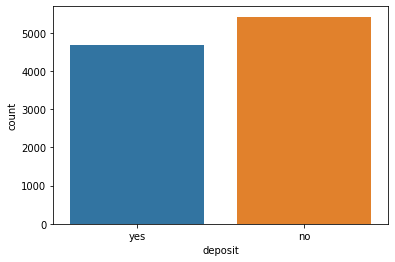

In [20]:
sns.countplot(data=df, x='deposit');

Вывод: целевой признак немного несблалансирован

### Задания 2 и 3

In [22]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


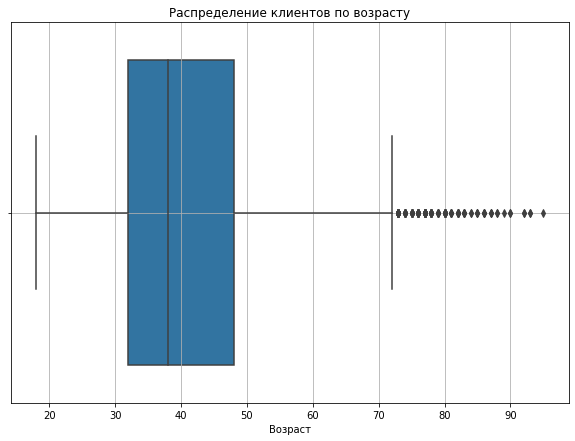

In [142]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(x=df['age'])
boxplot.set_title('Распределение клиентов по возрасту')
boxplot.set_xlabel('Возраст')
boxplot.grid()

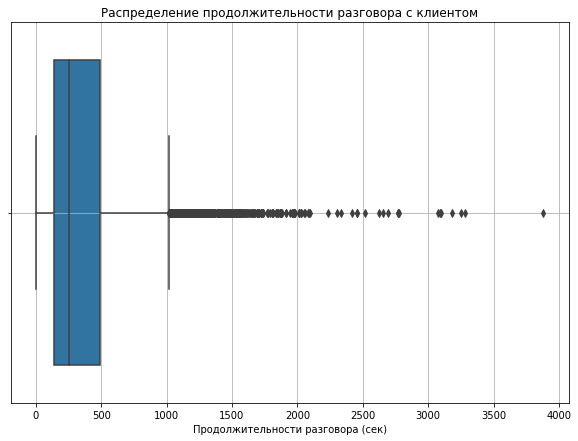

In [12]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(x=df['duration'])
boxplot.set_title('Распределение продолжительности разговора с клиентом')
boxplot.set_xlabel('Продолжительности разговора (сек)')
boxplot.grid()

### Задания 4 и 5

In [13]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
df.describe(include='object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [11]:
#df['month'].groupby('month').count()
df_grouped = df.groupby('month',as_index=False).count().sort_values(by='deposit',ascending=False)[['month','deposit']]

Text(0, 0.5, 'Количество разговоров с клиентом в месяц')

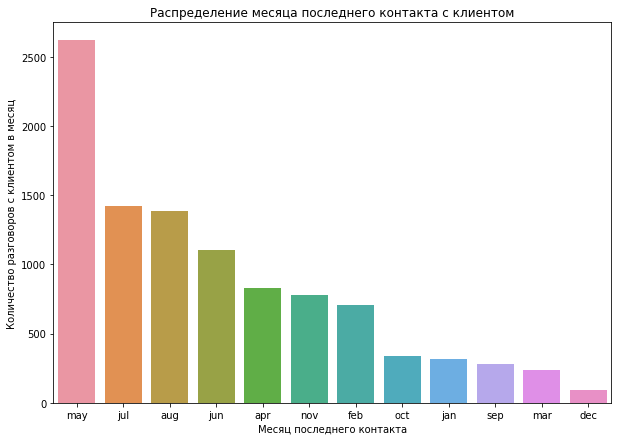

In [12]:
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=df_grouped,
    x='month',
    y='deposit'
)
barplot.set_title('Распределение месяца последнего контакта с клиентом');
barplot.set_xlabel('Месяц последнего контакта')
barplot.set_ylabel('Количество разговоров с клиентом в месяц')

Text(0.5, 1.0, 'Распределение сфер занятости клиентов банка')

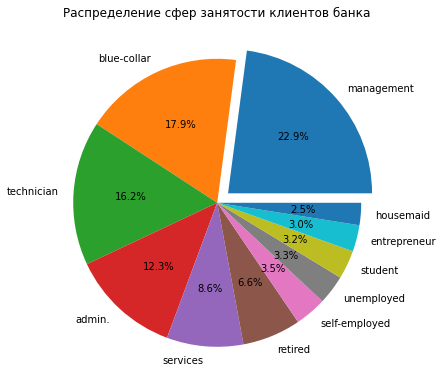

In [16]:
df_jobs = df['job'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    df_jobs,
    labels=df_jobs.index,
    autopct='%.1f%%',
    explode = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);
axes.set_title('Распределение сфер занятости клиентов банка') 

### Задание 6

In [17]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_poutcome = df.groupby(['poutcome','deposit'],as_index=False)['poutcome','deposit'].value_counts()

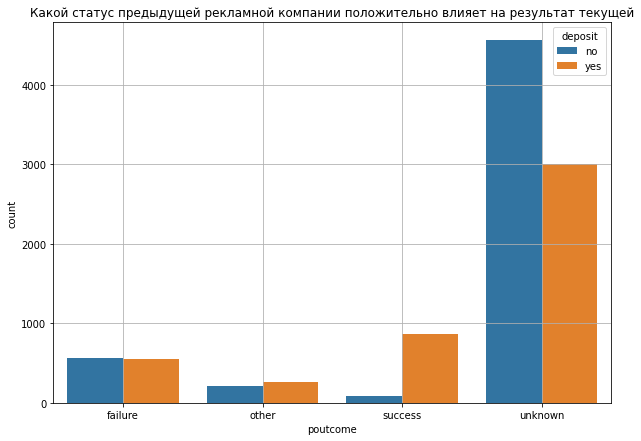

In [18]:
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=df_poutcome,
    x='poutcome',
    y='count',
    hue='deposit'
)
barplot.grid()
barplot.set_title('Какой статус предыдущей рекламной компании положительно влияет на результат текущей')

### Задание 7

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
months = []
month_count = []
month_neg_count = []
month_neg_per = []
for mon in df['month'].unique():
    mask1 = df['month']==mon
    mask2 = df['deposit']=='no'
    months.append(mon)
    month_count.append(df[mask1]['deposit'].count())
    month_neg_count.append(df[mask1 & mask2]['deposit'].count())
    month_neg_per.append(round(df[mask1 & mask2]['deposit'].count() / df[mask1]['deposit'].count(),4))

months_df = pd.DataFrame({
    'month' : months, 
    'total_decisions' : month_count, 
    'negative_decisions' : month_neg_count, 
    'negative_percent' : month_neg_per
})
months_df.sort_values(by='negative_percent',ascending=False)

,month,total_decisions,negative_decisions,negative_percent
0,may,2617,1776,0.6786
7,jan,319,194,0.6082
2,jul,1418,836,0.5896
5,nov,780,456,0.5846
3,aug,1385,775,0.5596
1,jun,1104,606,0.5489
8,feb,709,323,0.4556
10,apr,830,317,0.3819
4,oct,335,62,0.1851
11,sep,278,46,0.1655


### Задание 8

In [13]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

bins = pd.IntervalIndex.from_tuples([(0, 30), (30, 40), (40, 50), (50, 60), (60, 95)])
df['age_intervals'] = pd.cut(df['age'], bins)

In [14]:
df_age_intervals = df.groupby(['age_intervals','deposit'],as_index=False)['age_intervals','deposit'].value_counts()

Text(0.5, 1.0, 'В каких возрастных группах клиенты более склонны открывать депозит')

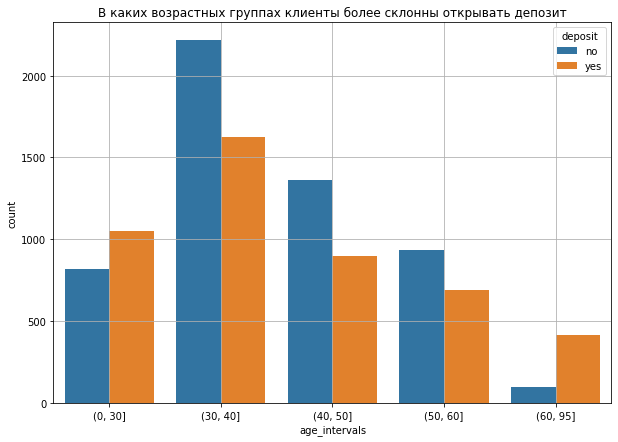

In [15]:
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=df_age_intervals,
    x='age_intervals',
    y='count',
    hue='deposit'
)
barplot.grid()
barplot.set_title('В каких возрастных группах клиенты более склонны открывать депозит')

### Задания 9 и 10

Text(0.5, 1.0, 'Клиенты какого семейного статуса более склонны открывать депозит')

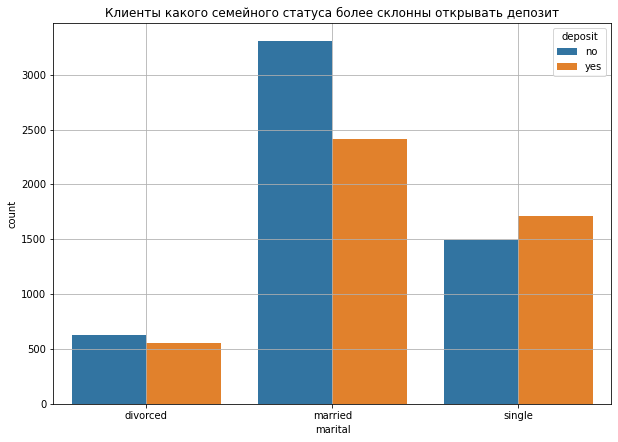

In [46]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df_marital = df.groupby(['marital','deposit'],as_index=False)['marital','deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=df_marital,
    x='marital',
    y='count',
    hue='deposit'
)
barplot.grid()
barplot.set_title('Клиенты какого семейного статуса более склонны открывать депозит')

Text(0.5, 1.0, 'Клиенты с каким образованием более склонны открывать депозит')

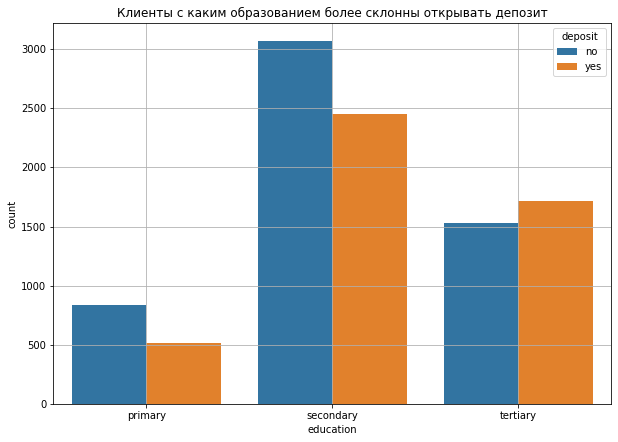

In [49]:
#постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df_education = df.groupby(['education','deposit'],as_index=False)['education','deposit'].value_counts()

fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=df_education,
    x='education',
    y='count',
    hue='deposit'
)
barplot.grid()
barplot.set_title('Клиенты с каким образованием более склонны открывать депозит')

Text(0.5, 1.0, 'Клиенты какого вида занятости более склонны открывать депозит')

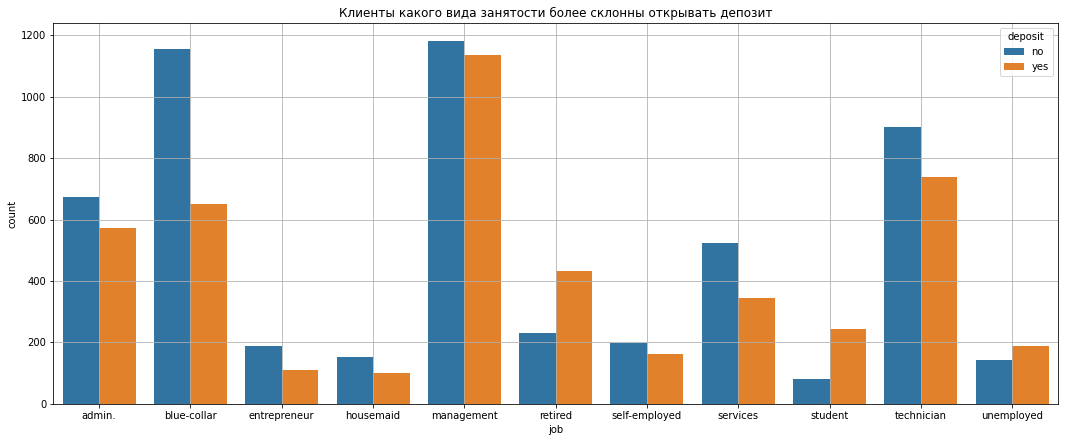

In [53]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df_job = df.groupby(['job','deposit'],as_index=False)['job','deposit'].value_counts()

fig = plt.figure(figsize=(18, 7))
barplot = sns.barplot(
    data=df_job,
    x='job',
    y='count',
    hue='deposit'
)
barplot.grid()
barplot.set_title('Клиенты какого вида занятости более склонны открывать депозит')

### Задание 11

In [16]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_positive = df[df['deposit'] == 'yes']

df_positive = df_positive.pivot_table(
    values='deposit',
    index='marital',
    columns='education',
    aggfunc='count'
)

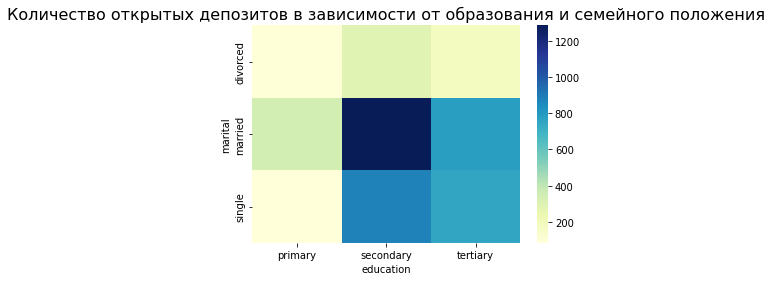

In [17]:
heatmap = sns.heatmap(data=df_positive, cmap='YlGnBu')
heatmap.set_title('Количество открытых депозитов в зависимости от образования и семейного положения', fontsize=16);

## Часть 3: преобразование данных

### Задание 1

In [18]:
# преобразуйте уровни образования
lb = LabelEncoder()
df['education'] = lb.fit_transform(df['education'])

In [19]:
df['education'].sum()

11995

In [20]:
df['age_intervals'] = lb.fit_transform(df['age_intervals'])

### Задания 2 и 3

In [21]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

In [17]:
round(df['deposit'].std(),3)

0.499

In [22]:
df['default'] = df['default'].apply(lambda x: 1 if x=='yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x=='yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [19]:
round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(),3)

0.635

In [23]:
df.drop(columns=['age'], axis=1, inplace=True)

### Задание 4

In [24]:
df.shape[1]

17

In [25]:
# создайте дамми-переменные
df_dummy = pd.get_dummies(df)

In [26]:
df_dummy.shape[1] - 1

44

### Задания 5 и 6

<AxesSubplot: >

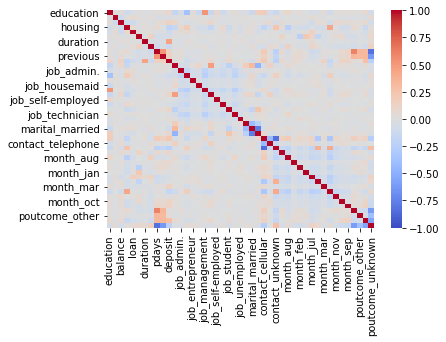

In [27]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df_dummy.corr(), vmin=-1, vmax=1, cmap= 'coolwarm')

In [28]:
df_corr = df_dummy.corr()
col, rows, corr = [], [], []
for i in df_corr.columns:
    for j in df_corr.columns:
        col.append(i)
        rows.append(j)
        corr.append(df_corr.loc[i,j])
df_ranged = pd.DataFrame({
    'columns' : col,
    'rows' : rows,
    'correlation' : corr   
})
bins = pd.IntervalIndex.from_tuples([(-1,-0.9),(-0.9,-0.75),(-0.75,-0.5),(-0.5,-0.25),(-0.25,0), (0,0.25),(0.25,0.5),(0.5,0.75),(0.75,0.9),(0.9,1)])
df_ranged['correlation_ranged'] = pd.cut(df_ranged['correlation'], bins)

df_ranged = df_ranged.groupby('correlation_ranged', as_index = False).count()

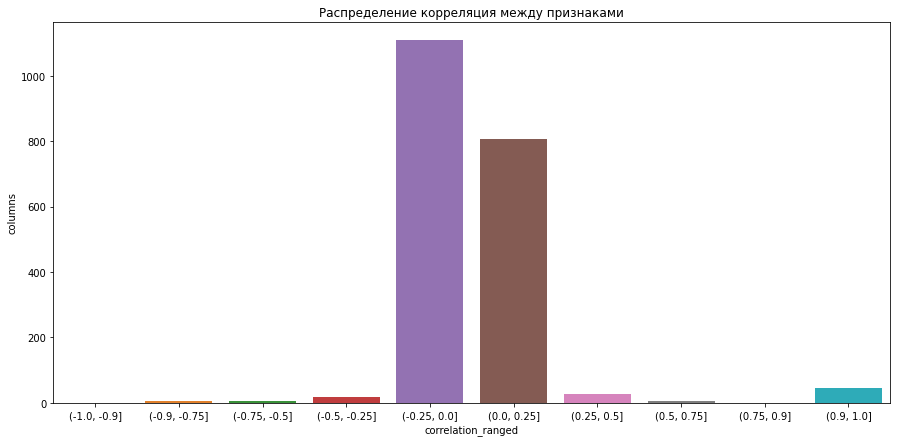

In [29]:
fig = plt.figure(figsize=(15, 7))

barplot = sns.barplot(
    data=df_ranged,
    x='correlation_ranged',
    y='columns'
)
barplot.set_title('Распределение корреляция между признаками');

In [31]:
df_dummy.corr().loc['deposit'][['poutcome_success','duration','contact_cellular']]

poutcome_success    0.288491
duration            0.457818
contact_cellular    0.223944
Name: deposit, dtype: float64

In [30]:
df_corr_plus = df_dummy.corr() >= 0.9
df_corr_minus = df_dummy.corr() <= -0.9

In [31]:
def corr_check (df):
    mult = {}
    for i in df.columns:
        for j in df.columns:
            if df.loc[i,j] == True and i != j:
                mult[i] = j       
    return mult

In [36]:
print(f'Коэффициенты корреляции выше 0,9 для: {corr_check(df_corr_plus)}')
print(f'Коэффициенты корреляции ниже -0,9 для: {corr_check(df_corr_minus)}')

Коэффициенты корреляции выше 0,9 для: {'age': 'age_intervals', 'age_intervals': 'age'}
Коэффициенты корреляции ниже -0,9 для: {}


### Задания 7 и 8

In [32]:
X = df_dummy.drop(['deposit'], axis=1)
y = df_dummy['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [33]:
# рассчитайте необходимые показатели
X_test.shape, X_train.shape

((3335, 44), (6770, 44))

In [34]:
round(y_test.mean(),2)

0.46

### Задание 9

In [35]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [36]:
# нормализуйте данные с помощью minmaxsxaler
best_features = ['balance','housing','loan','duration','campaign','pdays','previous','contact_cellular','contact_unknown',
                 'month_mar','month_may','month_oct','month_sep','poutcome_success','poutcome_unknown']
X_train = X_train[best_features]
X_test = X_test[best_features]

In [37]:
col_names = list(X_train.columns)
mm_scaler = preprocessing.MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.fit_transform(X_test)

In [38]:
X_train_mm = pd.DataFrame(X_train_mm, columns=col_names)
X_test_mm = pd.DataFrame(X_test_mm, columns=col_names)

In [39]:
round(X_train_mm['balance'].mean(),5)

0.46696

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [40]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver = 'sag',random_state=42,max_iter=1000)
log_reg.fit(X_train_mm, y_train)

y_test_pred = log_reg.predict(X_test_mm)
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

Accuracy: 0.8153
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1790
           1       0.79      0.81      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.81      0.82      0.81      3335
weighted avg       0.82      0.82      0.82      3335



### Задания 2,3,4

In [41]:
# обучите решающие деревья, настройте максимальную глубину
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=6, 
    random_state=42 
)
dt_clf.fit(X_train_mm, y_train)
y_train_pred = dt_clf.predict(X_train_mm)
y_test_pred = dt_clf.predict(X_test_mm)
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
#print(metrics.classification_report(y_test, y_test_pred))

Accuracy: 0.8164
Accuracy: 0.8036


In [42]:
train = {}
test = {}
for i in range(1,21):
    dt_clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i,random_state=42)
    dt_clf.fit(X_train_mm,y_train)
    y_train_pred = dt_clf.predict(X_train_mm)
    y_test_pred = dt_clf.predict(X_test_mm)
    train[i] = round(metrics.accuracy_score(y_train, y_train_pred),3)
    test[i] = round(metrics.accuracy_score(y_test, y_test_pred),3)
data = pd.DataFrame([train,test])
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.712,0.729,0.776,0.776,0.804,0.816,0.823,0.832,0.840,0.854,0.867,0.877,0.887,0.899,0.91,0.922,0.931,0.938,0.945,0.953
1,0.689,0.722,0.748,0.748,0.783,0.804,0.803,0.793,0.781,0.791,0.790,0.789,0.785,0.779,0.78,0.773,0.774,0.769,0.763,0.763


### Задание 5

In [43]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
dt_clf = tree.DecisionTreeClassifier(random_state=42)
param_grid = {'min_samples_leaf': [2, 5, 7, 10],
              'max_depth':[3,5,7]}
grid_search = GridSearchCV(dt_clf, param_grid=param_grid, verbose = True)


grid_search.fit(X_train_mm, y_train)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, random_state=42)


In [48]:
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=7, 
    min_samples_leaf=10,
    random_state=42 
)
dt_clf.fit(X_train_mm, y_train)
y_train_pred = dt_clf.predict(X_train_mm)
y_test_pred = dt_clf.predict(X_test_mm)

print('F1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score: 0.7993


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [65]:
# обучите на ваших данных случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10, 
    random_state=42 
)

rf_clf.fit(X_train_mm, y_train)
y_pred = rf_clf.predict(X_test_mm)
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall: {:.4f}'.format(metrics.recall_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

Accuracy: 0.8162
Recall: 0.8848
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задания 2 и 3

In [58]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
    learning_rate=0.05,
	max_depth=5, 
    n_estimators=300,
    min_samples_leaf=5, 
    random_state=42 
    )
gb.fit(X_train_mm, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [60]:
y_test_pred  = gb.predict(X_test_mm)

In [62]:
print('F1 score: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

F1 score: 0.8169


In [64]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1790
           1       0.76      0.88      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



### Задание 4

In [69]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt_clf', tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)),
    ('log_reg', linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)),
    ('gb', GradientBoostingClassifier( learning_rate=0.05, max_depth=5, n_estimators=300, min_samples_leaf=5, random_state=42))
]

s_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000))

s_clf.fit(X_train_mm, y_train)
y_pred_stack = s_clf.predict(X_test_mm)

In [70]:
print('Precision: {:.4f}'.format(metrics.precision_score(y_test, y_pred_stack)))

Precision: 0.7730


### Задание 5

In [89]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
X_train['deposit'] = y_train
X_train.corr().loc['deposit'].abs().nlargest(4)

deposit             1.000000
duration            0.462245
poutcome_success    0.291469
contact_unknown     0.243762
Name: deposit, dtype: float64

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna